In [2]:
# Step 1: Import the Dependencies

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Step 2: Load the Data
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
ratings.head()

movies = pd.read_csv("data/ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
# Step 3: Exploratory Data Analysis
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

# Taking a look at the user rating counts
# group the data by userId's and counts the number of ratings per user
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']

print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

user_freq.head()

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37
Mean number of ratings for a given user: 165.30.


,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


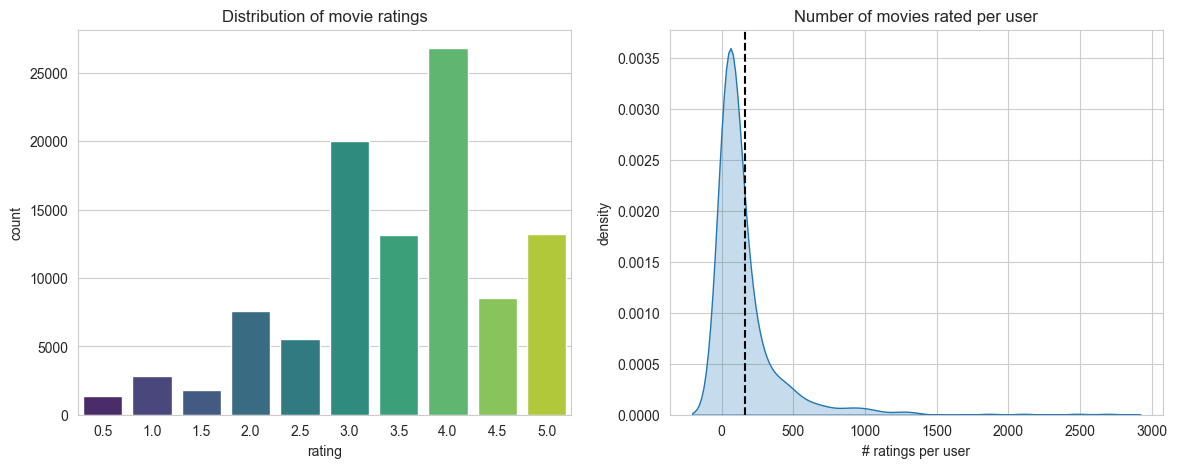

In [10]:
# We will plot the distribution of the number of ratings per user
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

In [12]:
# Which movie has the lowest and highest average rating?
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [14]:
# Highest rated movie

highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

# sure, this movie is the highest rated, but let's look at how many ratings it received:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [18]:
# okay, so the above movie only has 2 ratings, so it's not a good representation of the highest rated movie. Let's instead use the Bayesian average to get a better estimate of the true rating.
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

# We'll use the Bayesian average to estimate the true rating of each movie
# The formula is:
# Rm = (Nm * C + Rm * Cm) / (Nm + Cm)
# where:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

# Using the Bayesian average, we see that Shawshank Redemption, The Godfather, and Fight Club are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


In [20]:
# Now which movies are the worst rated, according to the Bayesian average?
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


In [24]:
# Step 4: Transforming the data

# We will be using a technique called collaborative filtering to generate user recommendations. Based on the assumption of "homophily" - similar users like similar things.
# Collab filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.
# The ifrst step is to tranform our data into a user-item matrix, also known as a utility matrix. Rows represent users and columns represent items. 

# The create_x function below outputs a sparse matrix X with four mapper dictionaires.
# -User_mapper: maps user id to a suer index
# -movie_mapper: maps movie id to movie index
# -user_inv_mapper: maps user index to user id
# -movie_inv_mapper: maps movie index to movie id

# We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

# The X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.


from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matric from ratings dataframe

    Args: 
        df: Pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """

    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [26]:
# We need to check the sparsity of our X matrix
# divide the number of non-zero elements by total number of elements as described in the euqation

sparsity = X.count_nonzero() / (X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

# Only 1.7% of cells in our user-item matrix are populated with ratings. User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

Matrix sparsity: 1.7%


In [27]:
# Write our matrix to a file
from scipy.sparse import save_npz

save_npz('data/user_item_matrix.npx', X)

In [30]:
# We will now find similar movies using k-Nearest neighbors

# This approach looks for the 
#  nearest neighbours of a given movie by identifying 
#  points in the dataset that are closest to movie 
# . kNN makes use of distance metrics such as:

# Cosine similarity
# Euclidean distance
# Manhattan distance
# Pearson correlation

# Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix.

from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbors for a given movie ID

    Args: 
        movie_id: id of the movie of interst
        X: user-item utlity matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Returns:
        list of k similar movie ID's
    """

    neighbor_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors = k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)
    neighbor = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0, k):
        n = neighbor.item(i)
        neighbor_ids.append(movie_inv_mapper[n])
    neighbor_ids.pop(0)
    return neighbor_ids

# find_similar_movies() takes in a movieId and user-item X matrix, and outputs a list of 
#  movies that are similar to the movieId of interest.

In [32]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

because you watched Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [33]:
# Here we will just play around with different matric arguments, like manhattan or euclidean

movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)


1. Cosine Similarity (Default)
What it measures: The cosine of the angle between two vectors (here, two movies’ rating vectors).
Interpretation: Measures how similar the direction of two vectors is, regardless of their magnitude.
Effect: Two movies are considered similar if the pattern of ratings is similar, even if the absolute number of ratings is different.
Typical for: Recommendation systems, text similarity, when magnitude (number of ratings) is less important than pattern.

2. Euclidean Distance
What it measures: The straight-line (L2) distance between two points (vectors) in high-dimensional space.
Interpretation: Measures the overall difference in ratings between two movies, taking both direction and magnitude into account.
Effect: Two movies are considered similar if their ratings are close in value for all users. If one movie is rated 5 by everyone and another is rated 1 by everyone, they are far apart, even if the pattern is the same.
Typical for: Clustering, when absolute values matter.

3. Manhattan Distance
What it measures: The sum of the absolute differences (L1 norm) between the elements of two vectors.
Interpretation: Like Euclidean, but adds up the absolute differences instead of squaring them.
Effect: Sensitive to the total difference in ratings, but less sensitive to outliers than Euclidean. Two movies are similar if the sum of their rating differences is small.
Typical for: High-dimensional data, when you want to reduce the effect of outliers.
What Changes in Output?


Cosine: Finds movies with similar rating patterns, regardless of how high or low the ratings are.
Euclidean/Manhattan: Finds movies that are not only rated similarly by the same users, but also have similar absolute rating values.


Example:
If Movie A and Movie B are both loved by the same users (all 5s for A, all 4s for B), cosine similarity will say they are very similar (same pattern), but Euclidean/Manhattan will see a difference (because 5 ≠ 4).
If Movie C and Movie D have the same average rating but are liked by different users, cosine similarity may see them as less similar, while Euclidean/Manhattan may also see them as different, but for a different reason.